# Analysis of Stream Gauges

This code was created to calculate slopes and perform our drought analysis on each individual wells used in this study.

To run this code, you need to follow all of the DataPreprocessing instructions.

Total time to run on my machine: TBA

In [2]:
# Packages and paths

import os
import numpy as np
import pandas as pd
#import earthpy as et
import scipy.stats as sp

# Local paths
inputpath = '../../Data/Input/RawData'
outputpath = '../../Data/Output/Local'

# Function to calculate slope using linear regression
def calculate_slope(y):
    x = np.arange(len(y))
    slope, _ = np.polyfit(x, y, 1)
    return slope

In [2]:
# ==== Reading in the data ====
filename_ts = 'USGSStreamgauges.txt'
filepath = os.path.join(inputpath, filename_ts)

# Open the file and read the first 10 lines
print("Supplemental Information about this file:")
with open(filepath, 'r') as file:
    for i in range(301):
        print(file.readline().strip())

stream_db = pd.read_csv(filepath, sep='\t',
                        # header=300,
                        skiprows=299,  # Adjust as needed
                        on_bad_lines="skip"
                    )
stream_db

# ---------------------------------- WARNING ----------------------------------------
# Some of the data that you have obtained from this U.S. Geological Survey database
# may not have received Director's approval. Any such data values are qualified
# as provisional and are subject to revision. Provisional data are released on the
# condition that neither the USGS nor the United States Government may be held liable
# for any damages resulting from its use.
#
# Additional info: https://waterdata.usgs.gov/provisional-data-statement/
#
# Contact:   gs-w_waterdata_support@usgs.gov
# retrieved: 2025-01-15 00:29:48 EST       (nadww02)
#
# Data for the following 271 site(s) are contained in this file
#    USGS 09379025 CHINLE CREEK AT CHINLE, AZ
#    USGS 09379050 LUKACHUKAI CREEK NEAR LUKACHUKAI, AZ
#    USGS 09379180 LAGUNA CREEK AT DENNEHOTSO, AZ
#    USGS 09379200 CHINLE CREEK NEAR MEXICAN WATER, AZ
#    USGS 09379910 COLORADO RIVER BELOW GLEN CANYON DAM, AZ
#    USGS 09380000 COLORADO RI

C:\Users\det19\AppData\Local\Temp\ipykernel_21644\688787305.py:10: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  stream_db = pd.read_csv(filepath, sep='\t',


,agency_cd,site_no,datetime,tz_cd,6121_00060,6121_00060_cd
0,5s,15s,20d,6s,14n,10s
1,USGS,09379025,2000-01-01 00:00,MST,4.30,A:[91]
2,USGS,09379025,2000-01-01 00:15,MST,4.30,A:[91]
3,USGS,09379025,2000-01-01 00:30,MST,4.60,A:[91]
4,USGS,09379025,2000-01-01 00:45,MST,3.60,A:[91]
...,...,...,...,...,...,...
140178204,USGS,352025111332401,2014-10-13 22:45,MST,0.0,A
140178205,USGS,352025111332401,2014-10-13 23:00,MST,0.0,A
140178206,USGS,352025111332401,2014-10-13 23:15,MST,0.0,A
140178207,USGS,352025111332401,2014-10-13 23:30,MST,0.0,A


In [4]:
stream_db = stream_db[1:140178208]
stream_db = stream_db.rename(columns={"agency_cd": "Agency",
                   "site_no": "ID",
                   "6121_00060": "Discharge (cfs)"}, errors="raise")
stream_db.head()

,Agency,ID,datetime,tz_cd,Discharge (cfs),6121_00060_cd
1,USGS,09379025,2000-01-01 00:00,MST,4.30,A:[91]
2,USGS,09379025,2000-01-01 00:15,MST,4.30,A:[91]
3,USGS,09379025,2000-01-01 00:30,MST,4.60,A:[91]
4,USGS,09379025,2000-01-01 00:45,MST,3.60,A:[91]
5,USGS,09379025,2000-01-01 01:00,MST,4.30,A:[91]


Basically when I tried to convert the date column into datetime, I noticed that metadata is being repeated for each station deep in the tables.  

In [6]:
stream_db.iloc[315825]

Agency                 agency_cd
ID                       site_no
datetime                datetime
tz_cd                      tz_cd
Discharge (cfs)       6122_00060
6121_00060_cd      6122_00060_cd
Name: 315826, dtype: object

In [10]:
# del stream_db.iloc[315825]
stream_db.iloc[315810:3158228]

,Agency,ID,datetime,tz_cd,Discharge (cfs),6121_00060_cd
315811,USGS,09379025,2025-01-14 21:30,MST,0.00,P
315812,USGS,09379025,2025-01-14 21:45,MST,0.00,P
315813,USGS,09379025,2025-01-14 22:00,MST,0.00,P
315814,#,NaN,NaN,NaN,NaN,NaN
315815,# Data provided for site 09379050,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
3158224,USGS,9382000,2011-11-22 17:45,MST,9.9,A
3158225,USGS,9382000,2011-11-22 18:00,MST,10.7,A
3158226,USGS,9382000,2011-11-22 18:15,MST,9.51,A
3158227,USGS,9382000,2011-11-22 18:30,MST,11.1,A


So to account for this I ran the following pre-processing of the original stream database file and renamed it to "filtered_streamgauges_test.csv".|

In [20]:
import csv

filepath = os.path.join(inputpath, filename_ts)  # Replace with your file path
output_file = "filtered_streamgauges_test.csv"  # Adjust output file extension if needed

# Define the index of the column to check for NaN (adjust index as needed)
column_to_check = 2  # Replace with the zero-based index of the column you want to check

with open(filepath, 'r') as infile, open(output_file, 'w', newline='') as outfile:
    reader = csv.reader(infile, delimiter='\t')  # Set delimiter to tab
    writer = csv.writer(outfile, delimiter='\t')  # Set delimiter to tab

    # Skip the first 299 lines
    for _ in range(299):
        next(reader)

    # Write header (if the 300th line is the header)
    header = next(reader)
    writer.writerow(header)

    # Process each line
    for row in reader:
        # Skip empty or malformed rows
        if len(row) <= column_to_check:  # Check if the row has enough columns
            print(f"Skipping malformed row: {row}")
            continue

        # Check if the target column is not empty (no NaN)
        if row[column_to_check].strip() != '':
            writer.writerow(row)


Skipping malformed row: ['#']
Skipping malformed row: ['# Data provided for site 09379050']
Skipping malformed row: ['#            TS   parameter     Description']
Skipping malformed row: ['#          6122       00060     Discharge, cubic feet per second']
Skipping malformed row: ['#']
Skipping malformed row: ['# Data-value qualification codes included in this output:']
Skipping malformed row: ['#     A  Approved for publication -- Processing and review completed.']
Skipping malformed row: ['#    90  Daily mean calculated from data on this day matches published daily mean to nearest hundredth']
Skipping malformed row: ['#    91  Daily mean calculated from data on this day matches published daily mean within 1 percent']
Skipping malformed row: ['#    92  Daily mean calculated from data on this day matches published daily mean within 5 percent']
Skipping malformed row: ['#    93  Daily mean calculated from data on this day matches published daily mean within 10 percent']
Skipping malform

Now Reading in the new table, hopefully without the metadata

In [2]:
filtered_streamdb = pd.read_csv("filtered_streamgauges_test.csv"
                                ,sep='\t'
                                ,on_bad_lines='skip')
filtered_streamdb.head()

C:\Users\det19\AppData\Local\Temp\ipykernel_25440\1479468543.py:1: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_streamdb = pd.read_csv("filtered_streamgauges_test.csv"


,agency_cd,site_no,datetime,tz_cd,6121_00060,6121_00060_cd
0,5s,15s,20d,6s,14n,10s
1,USGS,09379025,2000-01-01 00:00,MST,4.30,A:[91]
2,USGS,09379025,2000-01-01 00:15,MST,4.30,A:[91]
3,USGS,09379025,2000-01-01 00:30,MST,4.60,A:[91]
4,USGS,09379025,2000-01-01 00:45,MST,3.60,A:[91]


In [4]:
filtered_streamdb.iloc[315811:3158228]

,agency_cd,site_no,datetime,tz_cd,6121_00060,6121_00060_cd
315811,USGS,09379025,2025-01-14 21:30,MST,0.00,P
315812,USGS,09379025,2025-01-14 21:45,MST,0.00,P
315813,USGS,09379025,2025-01-14 22:00,MST,0.00,P
315814,agency_cd,site_no,datetime,tz_cd,6122_00060,6122_00060_cd
315815,5s,15s,20d,6s,14n,10s
...,...,...,...,...,...,...
3158223,USGS,9382000,2011-11-23 11:30,MST,12.0,A
3158224,USGS,9382000,2011-11-23 11:45,MST,13.5,A
3158225,USGS,9382000,2011-11-23 12:00,MST,11.6,A
3158226,USGS,9382000,2011-11-23 12:15,MST,10.7,A


So we still have repeated headers and that "5s 15s" thing that I don't know what it means.  We're going to run this code on the filtered data to get rid of those lines.

In [5]:
import csv

input_file = "filtered_streamgauges_test.csv"  # Replace with the filtered file path
output_file = "cleaned_streamgauges.csv"       # Final output file name

# Define a set of known "weird" values to filter out (e.g., "15s")
weird_values = {"5s","15s","20d","6s","14n","10s"}  # Add more values here if needed

with open(input_file, 'r') as infile, open(output_file, 'w', newline='') as outfile:
    reader = csv.reader(infile, delimiter='\t')  # Adjust delimiter as needed
    writer = csv.writer(outfile, delimiter='\t')  # Adjust delimiter as needed

    # Read the first header row
    header = next(reader)
    writer.writerow(header)  # Write the initial header to the output file

    # Process each line
    for row in reader:
        # Check if the row matches the header exactly
        if row == header:
            print(f"Skipping repeated header row: {row}")
            continue  # Skip repeated header rows

        # Check if the row contains "weird" values
        if any(cell in weird_values for cell in row):
            print(f"Skipping weird row: {row}")
            continue  # Skip rows with weird values

        # Write all other rows
        writer.writerow(row)


Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s', '15s', '20d', '6s', '14n', '10s']
Skipping weird row: ['5s

In [3]:
cleaned_streamdb = pd.read_csv("cleaned_streamgauges.csv"
                                ,sep='\t'
                                ,on_bad_lines='skip')
cleaned_streamdb.head()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [4]:
# Check the problem rows
cleaned_streamdb.iloc[315811:3158225]

,agency_cd,site_no,datetime,tz_cd,6121_00060,6121_00060_cd
315811,USGS,09379025,2025-01-14 21:45,MST,0.00,P
315812,USGS,09379025,2025-01-14 22:00,MST,0.00,P
315813,agency_cd,site_no,datetime,tz_cd,6122_00060,6122_00060_cd
315814,USGS,09379050,2000-01-26 00:00,MST,3.30,A:[91]
315815,USGS,09379050,2000-01-26 00:15,MST,3.60,A:[91]
...,...,...,...,...,...,...
3158220,USGS,9382000,2011-11-23 12:30,MST,9.51,A
3158221,USGS,9382000,2011-11-23 12:45,MST,12.0,A
3158222,USGS,9382000,2011-11-23 13:00,MST,9.9,A
3158223,USGS,9382000,2011-11-23 13:15,MST,9.9,A


The whole header line thing didn't work so we'll just delete it here

In [5]:
df = cleaned_streamdb[cleaned_streamdb['agency_cd'] != 'agency_cd']
df.iloc[315811:3158225]


,agency_cd,site_no,datetime,tz_cd,6121_00060,6121_00060_cd
315811,USGS,09379025,2025-01-14 21:45,MST,0.00,P
315812,USGS,09379025,2025-01-14 22:00,MST,0.00,P
315814,USGS,09379050,2000-01-26 00:00,MST,3.30,A:[91]
315815,USGS,09379050,2000-01-26 00:15,MST,3.60,A:[91]
315816,USGS,09379050,2000-01-26 00:30,MST,3.60,A:[91]
...,...,...,...,...,...,...
3158226,USGS,9382000,2011-11-23 14:00,MST,11.6,A
3158227,USGS,9382000,2011-11-23 14:15,MST,10.3,A
3158228,USGS,9382000,2011-11-23 14:30,MST,9.9,A
3158229,USGS,9382000,2011-11-23 14:45,MST,10.7,A


In [11]:
df.to_csv("streamgauges_bettercleaning.csv")

In [4]:
cleaned_streamdb = pd.read_csv("streamgauges_bettercleaning.csv"
                                # ,sep='\t'
                                ,on_bad_lines='skip')
cleaned_streamdb.head()

C:\Users\det19\AppData\Local\Temp\ipykernel_872\1762322783.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_streamdb = pd.read_csv("streamgauges_bettercleaning.csv"


,Unnamed: 0,agency_cd,site_no,datetime,tz_cd,6121_00060,6121_00060_cd
0,0,USGS,9379025,2000-01-01 00:00:00,MST,4.3,A:[91]
1,1,USGS,9379025,2000-01-01 00:15:00,MST,4.3,A:[91]
2,2,USGS,9379025,2000-01-01 00:30:00,MST,4.6,A:[91]
3,3,USGS,9379025,2000-01-01 00:45:00,MST,3.6,A:[91]
4,4,USGS,9379025,2000-01-01 01:00:00,MST,4.3,A:[91]


In [6]:
df = cleaned_streamdb
discharge_colname = '6121_00060'
# Making sure everything is the correct types
df['datetime'] = pd.to_datetime(df.datetime)
# Convert discharge column to numeric
df[discharge_colname] = pd.to_numeric(df[discharge_colname], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140174942 entries, 0 to 140174941
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Unnamed: 0     int64         
 1   agency_cd      object        
 2   site_no        int64         
 3   datetime       datetime64[ns]
 4   tz_cd          object        
 5   6121_00060     float64       
 6   6121_00060_cd  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 7.3+ GB


In [12]:
# Extract date from datetime
df['date'] = df['datetime'].dt.date  # Only keeps the date (YYYY-MM-DD)
daily_avg = df.groupby(['site_no', 'date'])['6121_00060'].mean().reset_index()

In [13]:
daily_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1437088 entries, 0 to 1437087
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   site_no     1437088 non-null  int64  
 1   date        1437088 non-null  object 
 2   6121_00060  1436595 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 32.9+ MB


In [14]:
daily_avg = daily_avg.rename(columns={"site_no": "ID",
                   "6121_00060": "Discharge (cfs)"}, errors="raise")
daily_avg

,ID,date,Discharge (cfs)
0,9379025,2000-01-01,9.273958
1,9379025,2000-01-02,12.959375
2,9379025,2000-01-11,9.764583
3,9379025,2000-01-12,10.281250
4,9379025,2000-01-14,15.154167
...,...,...,...
1437083,352025111332401,2014-10-09,0.000000
1437084,352025111332401,2014-10-10,0.000000
1437085,352025111332401,2014-10-11,0.000000
1437086,352025111332401,2014-10-12,0.000000


Exporting the daily average file because it's so much smaller

In [15]:
daily_avg.to_csv(outputpath+"/usgs_daily_discharge.csv")

In [16]:
# Add a zero-flow flag
daily_avg['Zero_Flow'] = daily_avg['Discharge (cfs)'].apply(lambda x: 1 if x == 0 else 0)

# Extract the year from the date
daily_avg['Year'] = pd.to_datetime(daily_avg['date']).dt.year

# Count zero-flow days per year
zero_flow_counts = daily_avg.groupby(['ID', 'Year'])['Zero_Flow'].sum().reset_index()
zero_flow_counts


,ID,Year,Zero_Flow
0,9379025,2000,201
1,9379025,2001,201
2,9379025,2002,244
3,9379025,2003,168
4,9379025,2004,168
...,...,...,...
4407,351848111323301,2014,251
4408,352025111332401,2011,86
4409,352025111332401,2012,347
4410,352025111332401,2013,347


In [24]:
# Load the stream gauge names CSV
gauge_names = pd.read_csv(inputpath+"/USGS_Gauge_Name_List.csv")

# Inspect the file to ensure it loaded correctly
print(gauge_names.head())


  Agency       ID                                      Name
0   USGS  9379025                CHINLE CREEK AT CHINLE, AZ
1   USGS  9379050      LUKACHUKAI CREEK NEAR LUKACHUKAI, AZ
2   USGS  9379180            LAGUNA CREEK AT DENNEHOTSO, AZ
3   USGS  9379200       CHINLE CREEK NEAR MEXICAN WATER, AZ
4   USGS  9379910  COLORADO RIVER BELOW GLEN CANYON DAM, AZ


In [26]:
# Merge the two datasets on the stream gauge ID
merged_data = zero_flow_counts.merge(gauge_names, left_on='ID', right_on='ID', how='left')

# Check the merged result
merged_data.head()


,ID,Year,Zero_Flow,Agency,Name
0,9379025,2000,201,USGS,"CHINLE CREEK AT CHINLE, AZ"
1,9379025,2001,201,USGS,"CHINLE CREEK AT CHINLE, AZ"
2,9379025,2002,244,USGS,"CHINLE CREEK AT CHINLE, AZ"
3,9379025,2003,168,USGS,"CHINLE CREEK AT CHINLE, AZ"
4,9379025,2004,168,USGS,"CHINLE CREEK AT CHINLE, AZ"


In [28]:
merged_data.to_csv(outputpath+"/zeroflowdays_peryear.csv")

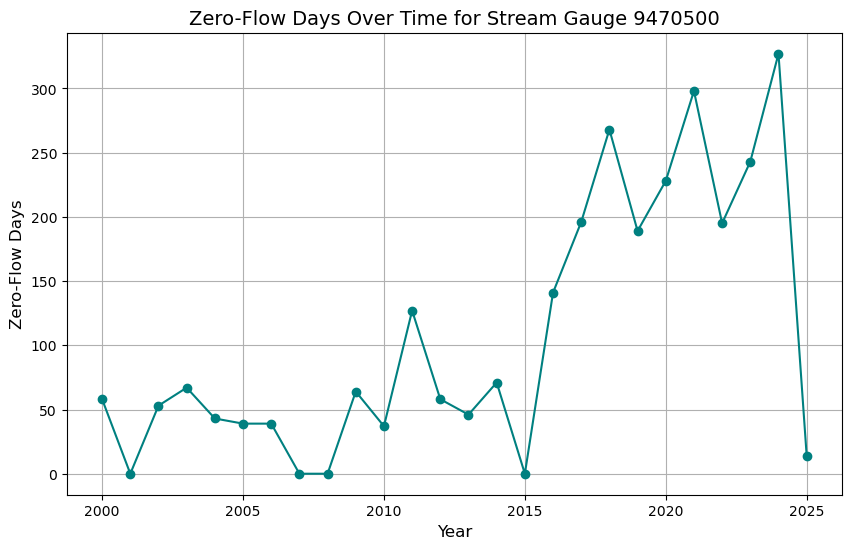

In [47]:
# Filter for a specific stream gauge
stream_id = 9470500  # Replace with the actual stream ID you want
stream_data = zero_flow_counts[zero_flow_counts['ID'] == stream_id]

import matplotlib.pyplot as plt

# Plot zero-flow days over time
plt.figure(figsize=(10, 6))
plt.plot(stream_data['Year'], stream_data['Zero_Flow'], marker='o', linestyle='-', color='teal')

# Add labels, title, and grid
plt.title(f'Zero-Flow Days Over Time for Stream Gauge {stream_id}', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Zero-Flow Days', fontsize=12)
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()


In [31]:
# Filter for stream gauges with "San Pedro" in their names (case-insensitive)
filtered_keyword = merged_data[merged_data['Name'].str.contains('San Pedro', case=False, na=False)]

# Check the filtered result
filtered_keyword


,ID,Year,Zero_Flow,Agency,Name
1493,9470500,2000,58,USGS,"SAN PEDRO RIVER AT PALOMINAS, AZ."
1494,9470500,2001,0,USGS,"SAN PEDRO RIVER AT PALOMINAS, AZ."
1495,9470500,2002,53,USGS,"SAN PEDRO RIVER AT PALOMINAS, AZ."
1496,9470500,2003,67,USGS,"SAN PEDRO RIVER AT PALOMINAS, AZ."
1497,9470500,2004,43,USGS,"SAN PEDRO RIVER AT PALOMINAS, AZ."
...,...,...,...,...,...
1761,9472050,2021,310,USGS,"SAN PEDRO R AT REDINGTON BRIDGE NR REDINGTON, AZ"
1762,9472050,2022,288,USGS,"SAN PEDRO R AT REDINGTON BRIDGE NR REDINGTON, AZ"
1763,9472050,2023,339,USGS,"SAN PEDRO R AT REDINGTON BRIDGE NR REDINGTON, AZ"
1764,9472050,2024,313,USGS,"SAN PEDRO R AT REDINGTON BRIDGE NR REDINGTON, AZ"


In [33]:
filtered_keyword['Name'].unique()

array(['SAN PEDRO RIVER AT PALOMINAS, AZ.',
       'SAN PEDRO RIVER AT CHARLESTON, AZ',
       'SAN PEDRO RIVER NEAR TOMBSTONE, AZ',
       'SAN PEDRO RIVER AT ST DAVID, AZ',
       'SAN PEDRO R AT REDINGTON BRIDGE NR REDINGTON, AZ'], dtype=object)

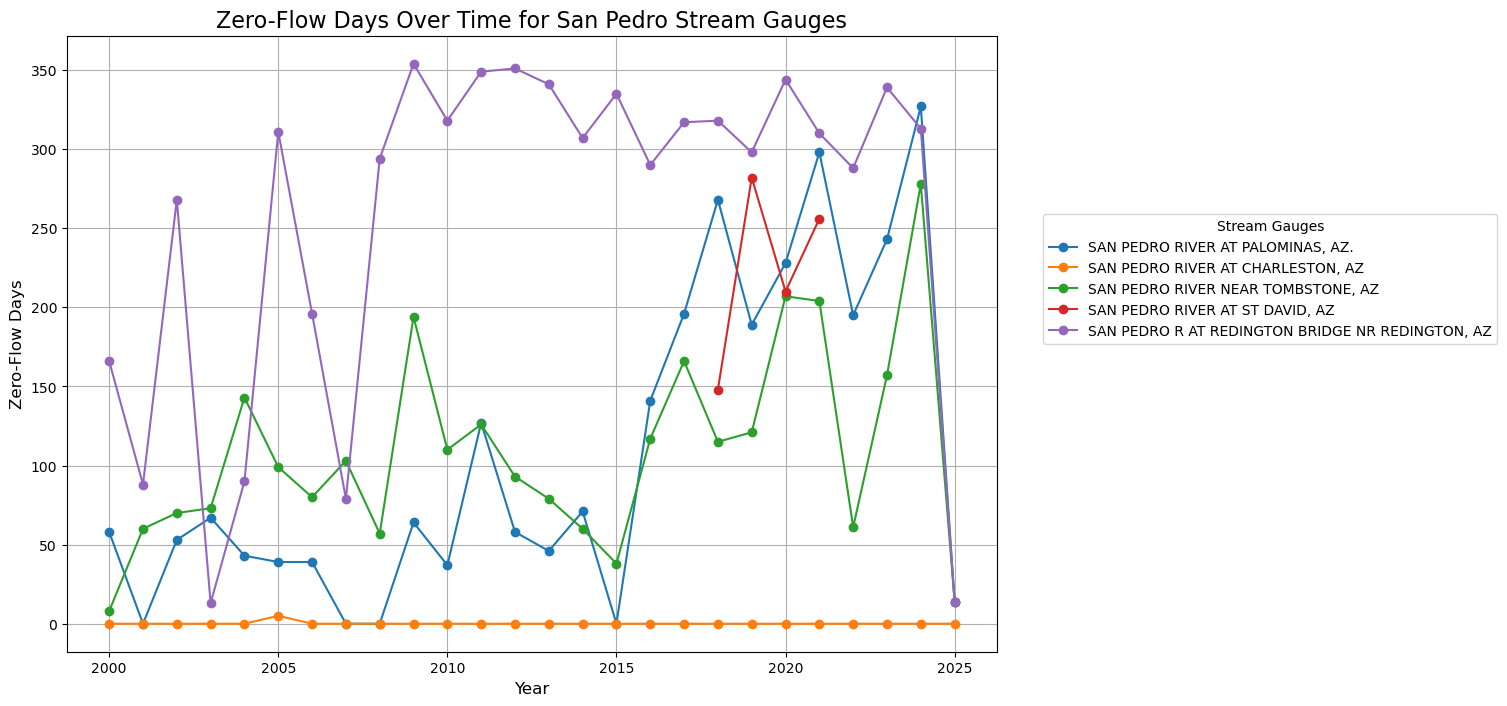

In [37]:
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(12, 8))

# Plot each gauge
for gauge_id, gauge_data in filtered_keyword.groupby('ID'):
    plt.plot(
        gauge_data['Year'], 
        gauge_data['Zero_Flow'], 
        marker='o', 
        label=gauge_data['Name'].iloc[0]  # Use the gauge name for the legend
    )

# Add labels, title, and legend
plt.title('Zero-Flow Days Over Time for San Pedro Stream Gauges', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Zero-Flow Days', fontsize=12)
plt.legend(title="Stream Gauges", loc=[1.05,0.5],fontsize=10)
plt.grid(True)

# Show the plot
plt.show()


In [41]:
# Filter for stream gauges with keyword in their names (case-insensitive)
keyword = "Gila River"
filtered_keyword = merged_data[merged_data['Name'].str.contains(keyword, case=False, na=False)]

# Check the filtered result
filtered_keyword


,ID,Year,Zero_Flow,Agency,Name
1195,9439000,2003,0,USGS,"GILA RIVER AT DUNCAN, AZ"
1196,9439000,2004,0,USGS,"GILA RIVER AT DUNCAN, AZ"
1197,9439000,2005,15,USGS,"GILA RIVER AT DUNCAN, AZ"
1198,9439000,2006,45,USGS,"GILA RIVER AT DUNCAN, AZ"
1199,9439000,2007,4,USGS,"GILA RIVER AT DUNCAN, AZ"
...,...,...,...,...,...
3906,9520500,2021,0,USGS,"GILA RIVER NEAR DOME, AZ"
3907,9520500,2022,0,USGS,"GILA RIVER NEAR DOME, AZ"
3908,9520500,2023,0,USGS,"GILA RIVER NEAR DOME, AZ"
3909,9520500,2024,0,USGS,"GILA RIVER NEAR DOME, AZ"


In [42]:
# See how many stream gauges that actually is
filtered_keyword['Name'].unique()

array(['GILA RIVER AT DUNCAN, AZ', 'GILA RIVER NEAR CLIFTON, AZ',
       'GILA RIVER AT HEAD OF SAFFORD VALLEY, NR SOLOMON,',
       'GILA RIVER AT CALVA, AZ.', 'GILA RIVER BELOW COOLIDGE DAM, AZ.',
       'GILA RIVER AT WINKELMAN, ARIZ.', 'GILA RIVER AT KELVIN, AZ.',
       'GILA RIVER AT ATTAWAY, AZ', 'GILA RIVER NEAR MARICOPA, AZ.',
       'GILA RIVER AT ESTRELLA PARKWAY, NEAR GOODYEAR, AZ',
       'GILA RIVER BELOW PAINTED ROCK DAM, AZ',
       'GILA RIVER NEAR DATELAND, AZ', 'GILA RIVER NEAR DOME, AZ'],
      dtype=object)

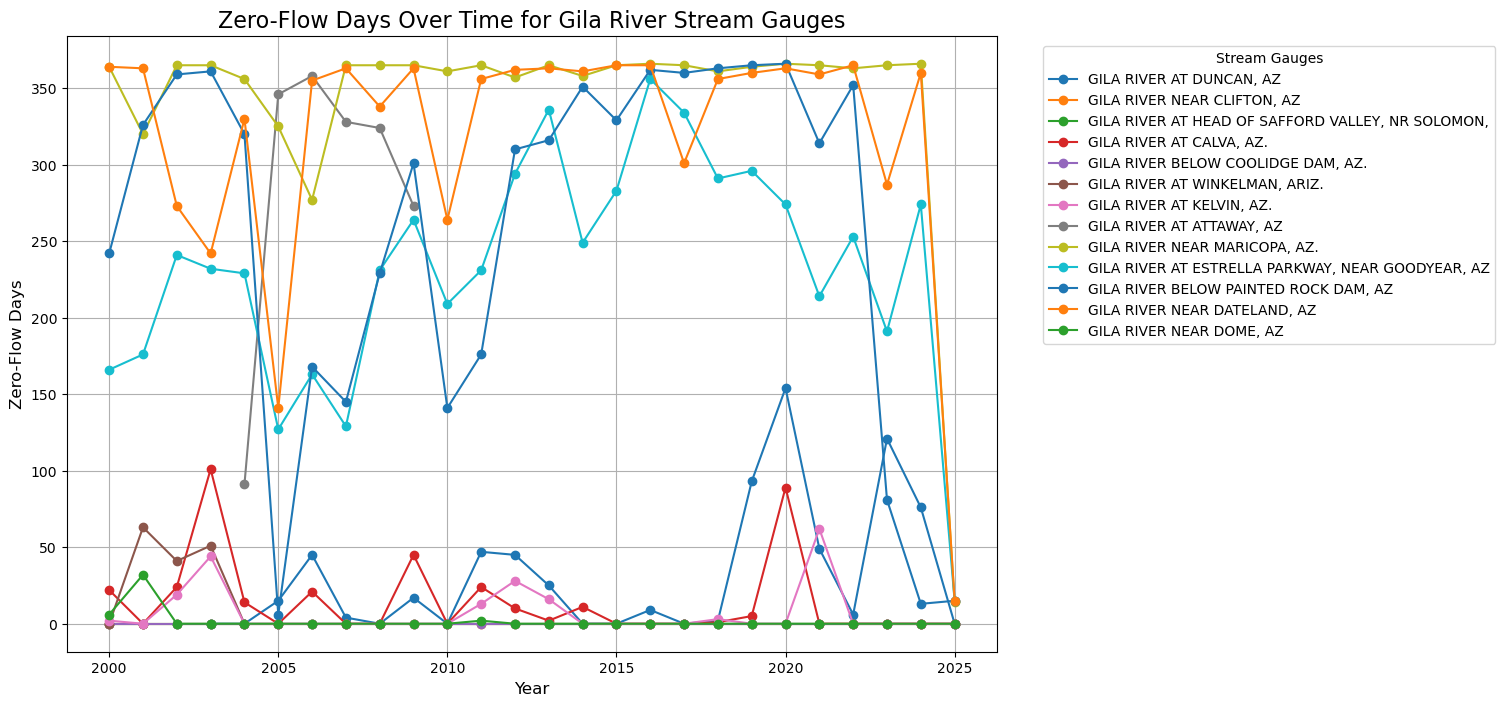

In [43]:
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(12, 8))

# Plot each gauge
for gauge_id, gauge_data in filtered_keyword.groupby('ID'):
    plt.plot(
        gauge_data['Year'], 
        gauge_data['Zero_Flow'], 
        marker='o', 
        label=gauge_data['Name'].iloc[0]  # Use the gauge name for the legend
    )

# Add labels, title, and legend
plt.title('Zero-Flow Days Over Time for '+keyword+' Stream Gauges', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Zero-Flow Days', fontsize=12)
plt.legend(title="Stream Gauges", loc=[1.05,0.5],fontsize=10)
plt.grid(True)

# Show the plot
plt.show()


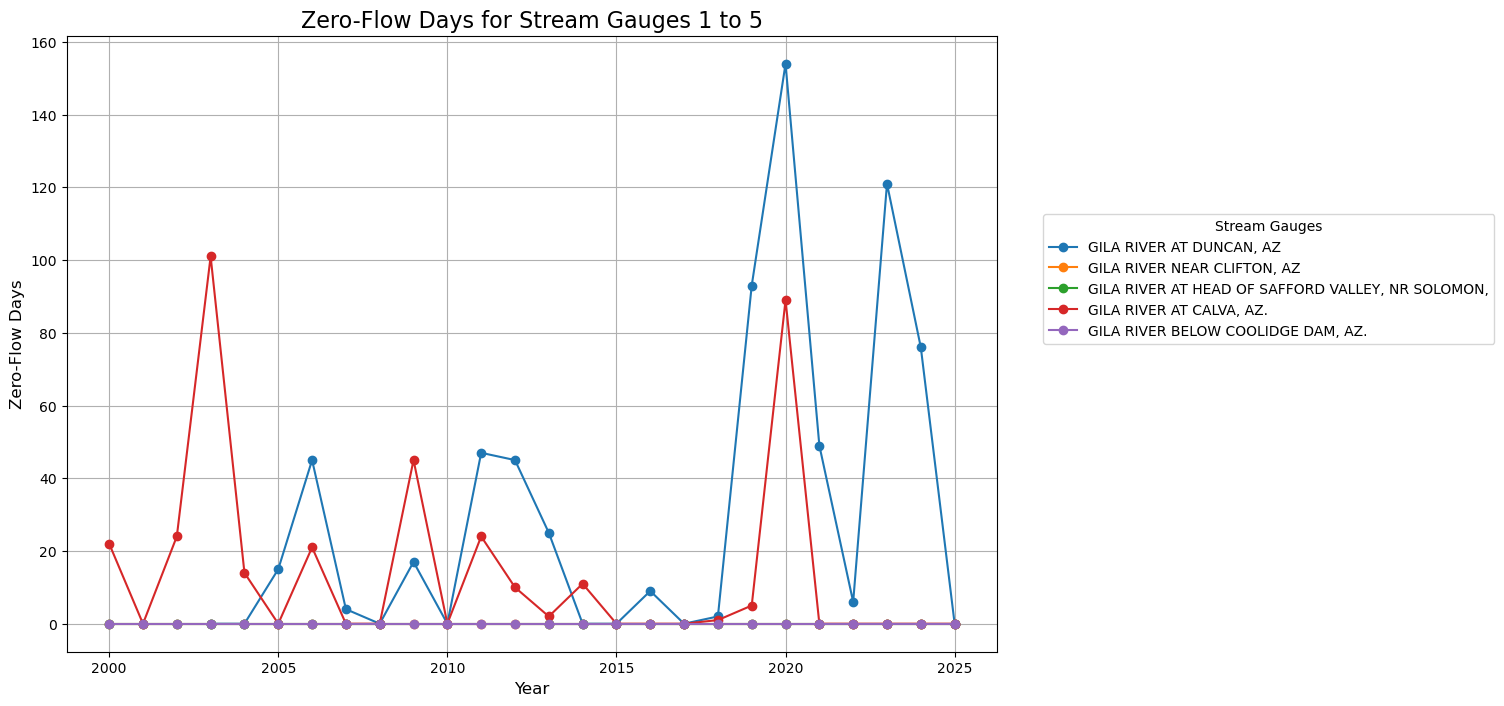

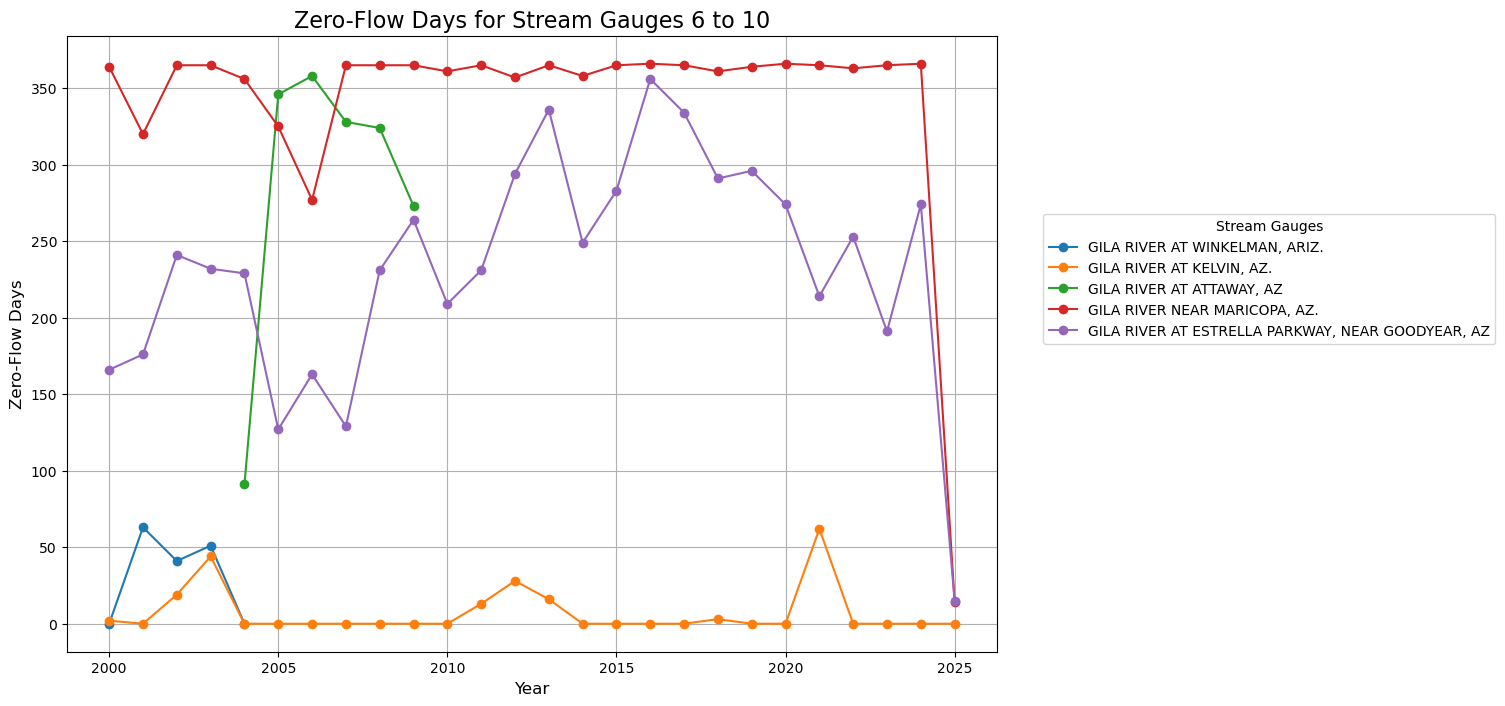

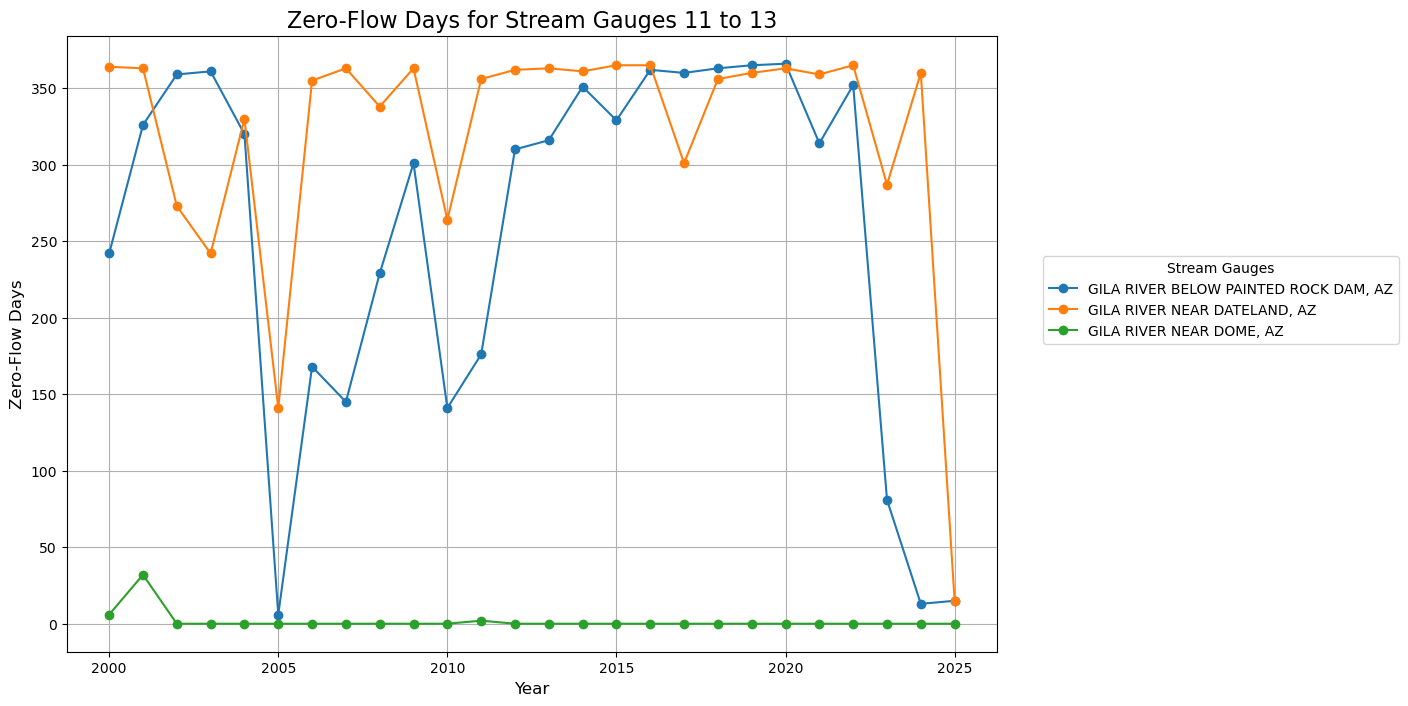

In [46]:
# Set the limit for gauges per plot
limit = 5

# Get a list of unique stream IDs
unique_gauges = filtered_keyword['ID'].unique()

# Loop through the gauges in chunks of the specified limit
for i in range(0, len(unique_gauges), limit):
    subset_gauges = unique_gauges[i:i+limit]  # Get the current chunk of gauges
    
    # Filter the data for these gauges
    subset_data = filtered_keyword[filtered_keyword['ID'].isin(subset_gauges)]
    
    # Plot the subset
    plt.figure(figsize=(12, 8))
    for gauge_id, gauge_data in subset_data.groupby('ID'):
        plt.plot(
            gauge_data['Year'], 
            gauge_data['Zero_Flow'], 
            marker='o', 
            label=gauge_data['Name'].iloc[0]
        )
    
    # Add labels, title, and legend
    plt.title(f'Zero-Flow Days for Stream Gauges {i+1} to {i+len(subset_gauges)}', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Zero-Flow Days', fontsize=12)
    plt.legend(title="Stream Gauges",loc=[1.05,0.5], fontsize=10)
    plt.grid(True)
    
    # Show the plot
    plt.show()
